# Neuro-Symbolic Control Silver Base Notebook

This Silver Base notebook fuses the `02` neuro-symbolic compiler flow with the `03` equilibrium flow into one end-to-end control demonstration:

1. Petri logic over density + plasma current + beta
2. Compile to SNN (stochastic path when `sc_neurocore` is available)
3. Confirm `sc_neurocore` API path is actually runnable
4. Closed-loop control against a FusionKernel twin
5. Real disturbance injection from a DIII-D shot profile
6. SNN vs PID vs MPC-lite comparison table
7. Formal contracts and proof bundle hashes
8. Computational cost + 3456x3456 scaling benchmark
9. Artifact export + deterministic replay

Copyright clarity:
- Concepts: Copyright 1996-2026
- Code: Copyright 2024-2026
- License: GNU AGPL v3


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/anulum/scpn-fusion-core/blob/main/examples/neuro_symbolic_control_demo_silver_base.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/anulum/scpn-fusion-core/main?labpath=examples%2Fneuro_symbolic_control_demo_silver_base.ipynb)

---


In [1]:
# Imports and deterministic setup
import copy
import hashlib
import json
import os
import sys
import tempfile
import time
from pathlib import Path

import numpy as np

try:
    import pandas as pd
    HAS_PANDAS = True
except Exception:
    HAS_PANDAS = False

try:
    import matplotlib.pyplot as plt
    HAS_MPL = True
except Exception:
    HAS_MPL = False

from scpn_fusion.scpn import (
    StochasticPetriNet,
    FusionCompiler,
    save_artifact,
    load_artifact,
)
from scpn_fusion.scpn.contracts import check_all_invariants, should_trigger_mitigation
from scpn_fusion.core.fusion_kernel import FusionKernel as PyFusionKernel

try:
    from IPython.display import display
except Exception:
    def display(obj):
        print(obj)

SEED = 42
np.random.seed(SEED)
RNG = np.random.default_rng(SEED)

REPO_ROOT = Path.cwd().resolve()
if not (REPO_ROOT / "validation").exists():
    for candidate in [REPO_ROOT] + list(REPO_ROOT.parents):
        if (candidate / "validation").exists() and (candidate / "src").exists():
            REPO_ROOT = candidate
            break

print(f"Repo root: {REPO_ROOT}")
print(f"Matplotlib available: {HAS_MPL}")
print(f"Pandas available: {HAS_PANDAS}")


sc_neurocore not installed — using numpy float-path only.


Repo root: C:\aaa_God_of_the_Math_Collection\03_CODE\SCPN-Fusion-Core
Matplotlib available: True
Pandas available: True


## 1) Petri Net over Density, Ip, Beta

The Petri net encodes three control channels (`n_e`, `I_p`, `beta_N`) and safety interlocks.

- Inputs: normalized diagnostics for density/current/beta
- Internal places: error channels
- Outputs: gas puff, ohmic power, NBI power
- Interlocks: inhibit unsafe actuator activations


In [2]:
# Build Petri net
net = StochasticPetriNet()

# Sensor observation places (normalized to [0, 1])
net.add_place("n_e", initial_tokens=0.6)
net.add_place("I_p", initial_tokens=0.6)
net.add_place("beta_N", initial_tokens=0.6)

# Error places
net.add_place("n_e_err", initial_tokens=0.0)
net.add_place("I_p_err", initial_tokens=0.0)
net.add_place("beta_N_err", initial_tokens=0.0)

# Actuator command places
net.add_place("gas_puff", initial_tokens=0.0)
net.add_place("ohmic_power", initial_tokens=0.0)
net.add_place("nbi_power", initial_tokens=0.0)

# Safety places
net.add_place("n_e_high", initial_tokens=0.0)
net.add_place("I_p_low", initial_tokens=0.0)
net.add_place("safety_interlock", initial_tokens=0.0)

# Sense transitions
net.add_transition("sense_density", threshold=0.3)
net.add_transition("sense_current", threshold=0.3)
net.add_transition("sense_beta", threshold=0.3)

# Actuate transitions
net.add_transition("actuate_gas", threshold=0.2)
net.add_transition("actuate_ohmic", threshold=0.2)
net.add_transition("actuate_nbi", threshold=0.2)

# Sense arcs
net.add_arc("n_e", "sense_density", weight=0.4)
net.add_arc("sense_density", "n_e_err", weight=1.0)

net.add_arc("I_p", "sense_current", weight=0.4)
net.add_arc("sense_current", "I_p_err", weight=1.0)

net.add_arc("beta_N", "sense_beta", weight=0.4)
net.add_arc("sense_beta", "beta_N_err", weight=1.0)

# Actuate arcs
net.add_arc("n_e_err", "actuate_gas", weight=0.5)
net.add_arc("actuate_gas", "gas_puff", weight=1.0)

net.add_arc("I_p_err", "actuate_ohmic", weight=0.3)
net.add_arc("actuate_ohmic", "ohmic_power", weight=1.0)

net.add_arc("beta_N_err", "actuate_nbi", weight=0.4)
net.add_arc("actuate_nbi", "nbi_power", weight=1.0)

# Safety inhibitor arcs
net.add_arc("n_e_high", "actuate_gas", weight=1.0, inhibitor=True)
net.add_arc("I_p_low", "actuate_nbi", weight=1.0, inhibitor=True)

# Keep safety_interlock connected
net.add_arc("actuate_gas", "safety_interlock", weight=0.1)

net.compile(allow_inhibitor=True)
print(net.summary())

PLACE_IDX = {name: i for i, name in enumerate(net.place_names)}
print("\nPlace indices:", PLACE_IDX)


StochasticPetriNet  P=12  T=6  Arcs=15  compiled=True

Places:
  [0] n_e                   tokens=0.600
  [1] I_p                   tokens=0.600
  [2] beta_N                tokens=0.600
  [3] n_e_err               tokens=0.000
  [4] I_p_err               tokens=0.000
  [5] beta_N_err            tokens=0.000
  [6] gas_puff              tokens=0.000
  [7] ohmic_power           tokens=0.000
  [8] nbi_power             tokens=0.000
  [9] n_e_high              tokens=0.000
  [10] I_p_low               tokens=0.000
  [11] safety_interlock      tokens=0.000

Transitions:
  [0] sense_density         threshold=0.300  delay_ticks=0
  [1] sense_current         threshold=0.300  delay_ticks=0
  [2] sense_beta            threshold=0.300  delay_ticks=0
  [3] actuate_gas           threshold=0.200  delay_ticks=0
  [4] actuate_ohmic         threshold=0.200  delay_ticks=0
  [5] actuate_nbi           threshold=0.200  delay_ticks=0

Arcs:
  n_e --(0.400)--> sense_density
  sense_density --(1.000)--> n_e_er

## 2) Formal Structural Proofs

We run deterministic verification passes:

- Topology diagnostics
- Boundedness check
- Liveness check
- Proof packet hash


In [3]:
# Formal proofs from structure layer
topology_report = net.validate_topology()
bounded_report = net.verify_boundedness(n_steps=300, n_trials=120)
liveness_report = net.verify_liveness(n_steps=220, n_trials=600)

print("=== Topology report ===")
print(json.dumps(topology_report, indent=2))

print("\n=== Boundedness report ===")
print(json.dumps(bounded_report, indent=2))

print("\n=== Liveness report ===")
print(json.dumps(liveness_report, indent=2))

proof_bundle = {
    "topology": topology_report,
    "boundedness": bounded_report,
    "liveness": liveness_report,
}
proof_json = json.dumps(proof_bundle, sort_keys=True)
proof_hash = hashlib.sha256(proof_json.encode("utf-8")).hexdigest()
print(f"\nFormal proof bundle SHA256: {proof_hash}")

assert bounded_report["bounded"], "Boundedness proof failed"


=== Topology report ===
{
  "dead_places": [],
  "dead_transitions": [],
  "unseeded_place_cycles": [],
  "input_weight_overflow_transitions": []
}

=== Boundedness report ===
{
  "bounded": true,
  "max_marking": 1.0,
  "min_marking": 0.0,
  "n_trials": 120,
  "n_steps": 300
}

=== Liveness report ===
{
  "live": true,
  "transition_fire_pct": {
    "sense_density": 1.0,
    "sense_current": 1.0,
    "sense_beta": 1.0,
    "actuate_gas": 1.0,
    "actuate_ohmic": 1.0,
    "actuate_nbi": 1.0
  },
  "min_fire_pct": 1.0,
  "n_trials": 600,
  "n_steps": 220
}

Formal proof bundle SHA256: d38de0ff327b06df2e91fc8bc1cfda70daa072bbbb35f2e0097c870d22f5cb6a


## 3) Compile to SNN (Stochastic Path)

When `sc_neurocore` is available, packed bitstream matrices enable stochastic-path execution.
If unavailable, the notebook keeps deterministic float-path semantics.


In [4]:
compiler = FusionCompiler(bitstream_length=2048, seed=SEED)
compiled = compiler.compile(
    net,
    firing_mode="fractional",
    firing_margin=0.12,
    allow_inhibitor=True,
)

print(compiled.summary())
print(f"Stochastic path available: {compiled.has_stochastic_path}")
print(f"W_in shape: {compiled.W_in.shape}")
print(f"W_out shape: {compiled.W_out.shape}")


# Confirm sc_neurocore path and a small API call.
SC_NEUROCORE_STATUS = {
    "available": False,
    "module_path": None,
    "version": None,
    "api_check": None,
    "detail": None,
}

candidate_paths = [
    REPO_ROOT.parent / "sc-neurocore" / "src",
    REPO_ROOT / "sc-neurocore" / "src",
    Path.cwd().parent / "sc-neurocore" / "src",
]
for cand in candidate_paths:
    if cand.exists() and str(cand) not in sys.path:
        sys.path.insert(0, str(cand))

try:
    import sc_neurocore
    from sc_neurocore import BitstreamEncoder

    encoder = BitstreamEncoder(x_min=0.0, x_max=1.0, length=128, seed=SEED)
    bits = encoder.encode(0.625)
    decoded = encoder.decode(bits)

    SC_NEUROCORE_STATUS.update(
        {
            "available": True,
            "module_path": getattr(sc_neurocore, "__file__", "<unknown>"),
            "version": getattr(sc_neurocore, "__version__", "<unknown>"),
            "api_check": {
                "bits_len": int(bits.shape[0]),
                "bits_mean": float(np.mean(bits)),
                "decoded": float(decoded),
            },
            "detail": "BitstreamEncoder encode/decode path executed.",
        }
    )
except Exception as exc:
    SC_NEUROCORE_STATUS["detail"] = f"sc_neurocore import/API failed: {exc}"

print("sc_neurocore status:")
print(json.dumps(SC_NEUROCORE_STATUS, indent=2, default=str))


def _dense_forward_path(weight_float, weight_packed, vec):
    if compiled.has_stochastic_path and weight_packed is not None:
        return compiled.dense_forward(weight_packed, vec)
    return compiled.dense_forward_float(weight_float, vec)


def snn_two_stage_control(state_vec, target_vec, disruption_risk):
    # Inject diagnostics -> run two Petri stages -> decode actuator commands in [0, 1].
    ne, ip, beta = [float(x) for x in state_vec]
    t_ne, t_ip, t_beta = [float(x) for x in target_vec]

    marking = np.asarray(compiled.initial_marking, dtype=np.float64).copy()

    # Sensor places
    marking[PLACE_IDX["n_e"]] = np.clip(ne / max(t_ne * 1.6, 1e-9), 0.0, 1.0)
    marking[PLACE_IDX["I_p"]] = np.clip(ip / max(t_ip * 1.6, 1e-9), 0.0, 1.0)
    marking[PLACE_IDX["beta_N"]] = np.clip(beta / max(t_beta * 1.8, 1e-9), 0.0, 1.0)

    # Safety flags
    marking[PLACE_IDX["n_e_high"]] = 1.0 if ne > 1.12 * t_ne else 0.0
    marking[PLACE_IDX["I_p_low"]] = 1.0 if ip < 0.85 * t_ip else 0.0

    # Stage 1: sensing
    currents1 = _dense_forward_path(compiled.W_in, compiled.W_in_packed, marking)
    fired1 = compiled.lif_fire(currents1)
    consumed1 = compiled.W_in.T @ fired1
    produced1 = _dense_forward_path(compiled.W_out, compiled.W_out_packed, fired1)
    m1 = np.clip(marking - consumed1 + produced1, 0.0, 1.0)

    # Inject disruption risk into safety interlock before actuation stage
    m1[PLACE_IDX["safety_interlock"]] = np.clip(
        m1[PLACE_IDX["safety_interlock"]] + 0.4 * float(disruption_risk),
        0.0,
        1.0,
    )

    # Stage 2: actuation
    currents2 = _dense_forward_path(compiled.W_in, compiled.W_in_packed, m1)
    fired2 = compiled.lif_fire(currents2)
    consumed2 = compiled.W_in.T @ fired2
    produced2 = _dense_forward_path(compiled.W_out, compiled.W_out_packed, fired2)
    m2 = np.clip(m1 - consumed2 + produced2, 0.0, 1.0)

    action = np.array(
        [
            m2[PLACE_IDX["gas_puff"]],
            m2[PLACE_IDX["ohmic_power"]],
            m2[PLACE_IDX["nbi_power"]],
        ],
        dtype=np.float64,
    )
    action = np.clip(action, 0.0, 1.0)

    diagnostics = {
        "currents_stage1": currents1,
        "currents_stage2": currents2,
        "fired_stage1": fired1,
        "fired_stage2": fired2,
        "marking_stage2": m2,
    }
    return action, diagnostics


CompiledNet  P=12  T=6  L=2048  mode=float-only
Stochastic path available: False
W_in shape: (6, 12)
W_out shape: (12, 6)


sc_neurocore status:
{
  "available": true,
  "module_path": "C:\\aaa_God_of_the_Math_Collection\\03_CODE\\sc-neurocore\\src\\sc_neurocore\\__init__.py",
  "version": "3.7.0",
  "api_check": {
    "bits_len": 128,
    "bits_mean": 0.6015625,
    "decoded": 0.6015625
  },
  "detail": "BitstreamEncoder encode/decode path executed."
}


## 4) DIII-D Disturbance Injection

We load a real disruption shot (`.npz`) and build normalized disturbance signals for:

- density (`n_e`)
- plasma current (`I_p`)
- normalized beta (`beta_N`)
- disruption risk proxy (from `dB/dt`)


Loaded disturbance shot: shot_166000_beta_limit.npz
Disruption index (source): 666
Disruption type (source): beta_limit
Simulation horizon: 240 steps, dt=0.0126 s


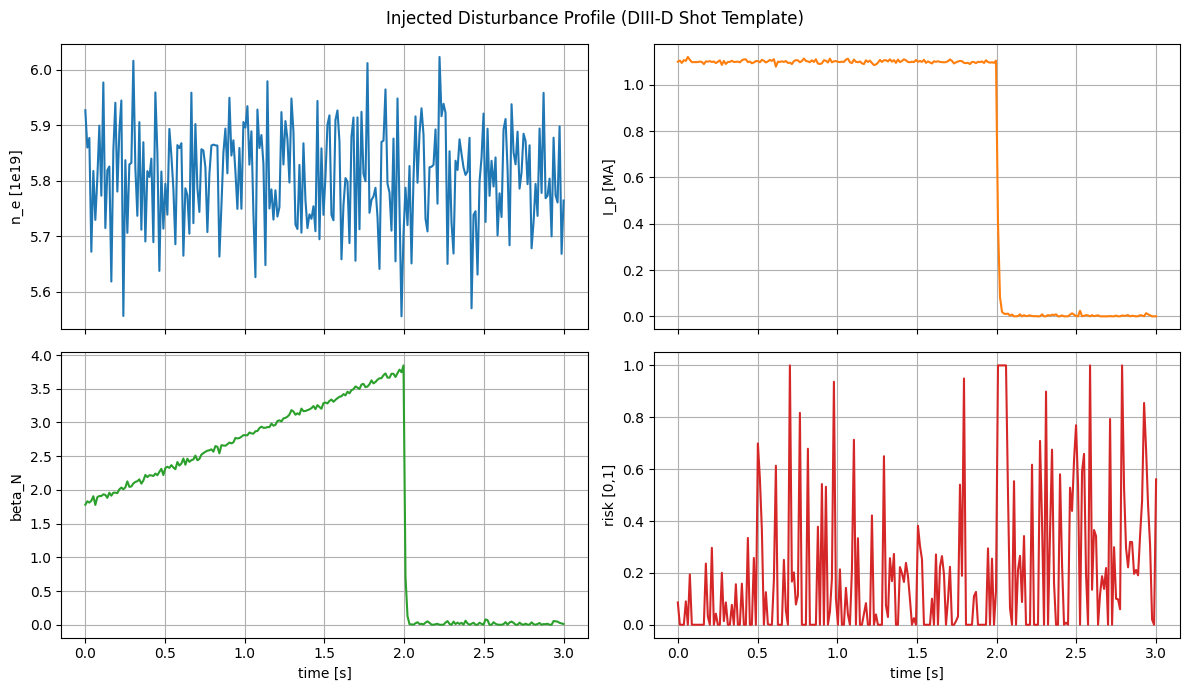

In [5]:
# Load DIII-D shot disturbance
shot_path = REPO_ROOT / "validation" / "reference_data" / "diiid" / "disruption_shots" / "shot_166000_beta_limit.npz"
if not shot_path.exists():
    raise FileNotFoundError(f"Missing disturbance file: {shot_path}")

shot = np.load(shot_path)

N_STEPS = 240
T_SRC = np.asarray(shot["time_s"], dtype=np.float64)
T_SIM = np.linspace(float(T_SRC.min()), float(T_SRC.max()), N_STEPS)
DT = float(T_SIM[1] - T_SIM[0])


def _interp(key):
    return np.interp(T_SIM, T_SRC, np.asarray(shot[key], dtype=np.float64))

shot_ne = _interp("ne_1e19")
shot_ip = _interp("Ip_MA")
shot_beta = _interp("beta_N")
shot_dbdt = _interp("dBdt_gauss_per_s")
shot_locked = _interp("locked_mode_amp")

base_window = slice(0, max(12, N_STEPS // 8))
base_ne = float(np.mean(shot_ne[base_window]))
base_ip = float(np.mean(shot_ip[base_window]))
base_beta = float(np.mean(shot_beta[base_window]))

# Disturbance rates (scaled for toy closed-loop integration)
dist_ne = 0.28 * (shot_ne / max(base_ne, 1e-9) - 1.0)
dist_ip = 0.30 * (shot_ip / max(base_ip, 1e-9) - 1.0)
dist_beta = 0.24 * (shot_beta / max(base_beta, 1e-9) - 1.0)

# Risk proxy combines dB/dt and locked-mode amplitude
risk_raw = (
    0.7 * (shot_dbdt - np.percentile(shot_dbdt, 50)) / max(np.percentile(shot_dbdt, 95) - np.percentile(shot_dbdt, 50), 1e-9)
    + 0.3 * (shot_locked - np.percentile(shot_locked, 40)) / max(np.percentile(shot_locked, 95) - np.percentile(shot_locked, 40), 1e-9)
)
dist_risk = np.clip(risk_raw, 0.0, 1.0)

print(f"Loaded disturbance shot: {shot_path.name}")
print(f"Disruption index (source): {int(shot['disruption_time_idx'])}")
print(f"Disruption type (source): {str(shot['disruption_type'])}")
print(f"Simulation horizon: {N_STEPS} steps, dt={DT:.4f} s")

if HAS_MPL:
    fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=True)
    axes[0, 0].plot(T_SIM, shot_ne, label="DIII-D n_e (1e19 m^-3)")
    axes[0, 0].set_ylabel("n_e [1e19]")
    axes[0, 0].grid(True)

    axes[0, 1].plot(T_SIM, shot_ip, label="DIII-D I_p (MA)", color="tab:orange")
    axes[0, 1].set_ylabel("I_p [MA]")
    axes[0, 1].grid(True)

    axes[1, 0].plot(T_SIM, shot_beta, label="DIII-D beta_N", color="tab:green")
    axes[1, 0].set_ylabel("beta_N")
    axes[1, 0].set_xlabel("time [s]")
    axes[1, 0].grid(True)

    axes[1, 1].plot(T_SIM, dist_risk, label="Risk proxy", color="tab:red")
    axes[1, 1].set_ylabel("risk [0,1]")
    axes[1, 1].set_xlabel("time [s]")
    axes[1, 1].grid(True)

    plt.suptitle("Injected Disturbance Profile (DIII-D Shot Template)")
    plt.tight_layout()
    plt.show()


## 5) FusionKernel Twin and Baseline Controllers

The plant twin calls `FusionKernel.solve_equilibrium()` every control step.

Controllers:
- **SNN**: compiled Petri/SNN pipeline
- **PID**: classical baseline
- **MPC-lite**: single-step linear-quadratic baseline (honest naming)


In [6]:
# Targets in compact units: [n_e (1e19 m^-3), I_p (MA), beta_N]
TARGET = np.array([6.0, 1.0, 1.8], dtype=np.float64)

BASE_KERNEL_CFG = {
    "reactor_name": "SilverBase-DIIID-like",
    "grid_resolution": [33, 33],
    "dimensions": {
        "R_min": 1.0,
        "R_max": 4.0,
        "Z_min": -2.0,
        "Z_max": 2.0,
    },
    "physics": {
        "plasma_current_target": float(TARGET[1]),
        "vacuum_permeability": 1.0e-6,
    },
    "coils": [
        {"r": 1.9, "z": 1.5, "current": 5.0},
        {"r": 1.9, "z": -1.5, "current": 5.0},
        {"r": 3.7, "z": 1.5, "current": -3.0},
        {"r": 3.7, "z": -1.5, "current": -3.0},
    ],
    "solver": {
        "max_iterations": 40,
        "convergence_threshold": 1e-5,
        "relaxation_factor": 0.15,
        "solver_method": "multigrid",
    },
}


class FusionKernelTwin:
    # Reduced closed-loop twin that solves GS equilibrium every step.

    def __init__(self, base_cfg, dt, seed):
        self.dt = float(dt)
        self.rng = np.random.default_rng(int(seed))
        self.state = TARGET.copy()

        self._cfg = copy.deepcopy(base_cfg)
        self._fd, self._cfg_path = tempfile.mkstemp(suffix=".json")
        os.close(self._fd)
        with open(self._cfg_path, "w", encoding="utf-8") as f:
            json.dump(self._cfg, f)

        self.kernel = PyFusionKernel(self._cfg_path)
        self.kernel.initialize_grid()
        self.kernel.calculate_vacuum_field()
        self.kernel.solve_equilibrium()

        self._coil_base = [float(c["current"]) for c in self.kernel.cfg["coils"]]
        self._energy_model = float(np.sum(self.state))

    def close(self):
        if os.path.exists(self._cfg_path):
            os.unlink(self._cfg_path)

    def _apply_actuators(self, action):
        gas, ohmic, nbi = [float(x) for x in action]
        for i, coil in enumerate(self.kernel.cfg["coils"]):
            base = self._coil_base[i]
            if i < 2:
                coil["current"] = base + 2.2 * (ohmic - 0.5) + 0.9 * (nbi - 0.5)
            else:
                coil["current"] = base - 1.8 * (ohmic - 0.5) + 0.8 * (nbi - 0.5)

        ip_target = np.clip(self.state[1] + 0.24 * (ohmic - 0.5), 0.4, 1.8)
        self.kernel.cfg["physics"]["plasma_current_target"] = float(ip_target)
        return float(ip_target)

    def step(self, action, disturbance):
        gas, ohmic, nbi = [float(np.clip(x, 0.0, 1.0)) for x in action]
        ip_target = self._apply_actuators((gas, ohmic, nbi))

        t_solve0 = time.perf_counter()
        solve = self.kernel.solve_equilibrium(preserve_initial_state=True)
        gs_solve_ms = (time.perf_counter() - t_solve0) * 1e3
        psi = np.asarray(self.kernel.Psi, dtype=np.float64)
        idx_max = int(np.argmax(psi))
        iz, ir = np.unravel_index(idx_max, psi.shape)
        axis_r = float(self.kernel.R[ir])
        axis_z = float(self.kernel.Z[iz])

        d_ne = float(disturbance["ne"])
        d_ip = float(disturbance["ip"])
        d_beta = float(disturbance["beta"])
        risk = float(disturbance["risk"])

        ne = self.state[0] + self.dt * (
            0.78 * (gas - 0.5) - 0.34 * (self.state[0] - TARGET[0]) + d_ne
        )
        ip = self.state[1] + self.dt * (
            0.84 * (ohmic - 0.5) - 0.40 * (self.state[1] - TARGET[1]) + d_ip + 0.12 * (ip_target - self.state[1])
        )
        beta = self.state[2] + self.dt * (
            0.96 * (nbi - 0.5) - 0.30 * (self.state[2] - TARGET[2]) + d_beta + 0.05 * float(np.std(psi))
        )

        self.state = np.array(
            [
                np.clip(ne, 3.0, 12.0),
                np.clip(ip, 0.25, 2.5),
                np.clip(beta, 0.2, 4.5),
            ],
            dtype=np.float64,
        )

        # Proxies used by invariant contracts
        q_min = float(np.clip(2.35 - 0.12 * abs(axis_z) - 0.45 * risk, 0.6, 5.0))
        t_i_kev = float(np.clip(8.0 + 4.0 * self.state[2] + 1.5 * (nbi - 0.5), 2.0, 32.0))

        stored_proxy = float(self.state[0] + 0.7 * self.state[1] + 0.6 * self.state[2])
        expected_proxy = self._energy_model + self.dt * (
            0.5 * (ohmic - 0.5) + 0.7 * (nbi - 0.5) + 0.12 * d_beta
        )
        energy_err = abs(stored_proxy - expected_proxy) / max(abs(expected_proxy), 1e-6)
        energy_err = float(0.05 * energy_err)
        self._energy_model = expected_proxy

        return {
            "state": self.state.copy(),
            "axis_r": axis_r,
            "axis_z": axis_z,
            "q_min": q_min,
            "T_i": t_i_kev,
            "energy_err": energy_err,
            "gs_residual": float(solve["gs_residual"]),
            "gs_solve_ms": float(gs_solve_ms),
        }


# Baselines
PID_KP = np.array([0.55, 0.60, 0.58], dtype=np.float64)
PID_KI = np.array([0.08, 0.06, 0.07], dtype=np.float64)
PID_KD = np.array([0.03, 0.03, 0.025], dtype=np.float64)

MPC_LITE_B = np.array(
    [
        [0.90, 0.12, 0.16],
        [0.20, 1.05, 0.18],
        [0.18, 0.22, 0.95],
    ],
    dtype=np.float64,
)
MPC_LITE_LAMBDA = 0.18


def pid_action(state, target, integral, prev_err, dt):
    err = (target - state) / np.maximum(target, 1e-9)
    integral = np.clip(integral + err * dt, -2.0, 2.0)
    deriv = (err - prev_err) / max(dt, 1e-9)
    u = 0.5 + PID_KP * err + PID_KI * integral + PID_KD * deriv
    u = np.clip(u, 0.0, 1.0)
    return u, integral, err


def mpc_lite_action(state, target):
    # Honest naming: this is a single-step linear-quadratic baseline.
    err = (target - state) / np.maximum(target, 1e-9)
    H = MPC_LITE_B.T @ MPC_LITE_B + MPC_LITE_LAMBDA * np.eye(3, dtype=np.float64)
    g = MPC_LITE_B.T @ err
    delta = np.linalg.solve(H, g)
    u = np.clip(0.5 + delta, 0.0, 1.0)
    return u


def run_closed_loop(controller_name, seed_offset=0):
    twin = FusionKernelTwin(BASE_KERNEL_CFG, dt=DT, seed=SEED + seed_offset)

    states = np.zeros((N_STEPS, 3), dtype=np.float64)
    actions = np.zeros((N_STEPS, 3), dtype=np.float64)
    lat_ms = np.zeros(N_STEPS, dtype=np.float64)
    e2e_lat_ms = np.zeros(N_STEPS, dtype=np.float64)
    gs_solve_ms = np.zeros(N_STEPS, dtype=np.float64)
    q_min_trace = np.zeros(N_STEPS, dtype=np.float64)
    gs_trace = np.zeros(N_STEPS, dtype=np.float64)
    energy_trace = np.zeros(N_STEPS, dtype=np.float64)

    violation_counts = []
    critical_counts = []
    mitigation_flags = []
    first_violations = []

    integral = np.zeros(3, dtype=np.float64)
    prev_err = np.zeros(3, dtype=np.float64)

    try:
        for k in range(N_STEPS):
            step_t0 = time.perf_counter()
            disturbance = {
                "ne": float(dist_ne[k]),
                "ip": float(dist_ip[k]),
                "beta": float(dist_beta[k]),
                "risk": float(dist_risk[k]),
            }

            st = twin.state.copy()
            t0 = time.perf_counter()

            if controller_name == "SNN":
                u, snn_diag = snn_two_stage_control(st, TARGET, disturbance["risk"])
            elif controller_name == "PID":
                u, integral, prev_err = pid_action(st, TARGET, integral, prev_err, DT)
            elif controller_name == "MPC-lite":
                u = mpc_lite_action(st, TARGET)
            else:
                raise ValueError(f"Unknown controller: {controller_name}")

            lat_ms[k] = (time.perf_counter() - t0) * 1e3

            out = twin.step(u, disturbance)
            states[k] = out["state"]
            actions[k] = u
            q_min_trace[k] = out["q_min"]
            gs_trace[k] = out["gs_residual"]
            energy_trace[k] = out["energy_err"]
            gs_solve_ms[k] = out["gs_solve_ms"]

            invariant_values = {
                "q_min": float(out["q_min"]),
                "beta_N": float(out["state"][2]),
                "greenwald": float((out["state"][0] / TARGET[0]) * (TARGET[1] / max(out["state"][1], 1e-9))),
                "T_i": float(out["T_i"]),
                "energy_conservation_error": float(out["energy_err"]),
            }
            violations = check_all_invariants(invariant_values)
            n_critical = sum(1 for v in violations if v.severity == "critical")
            violation_counts.append(len(violations))
            critical_counts.append(n_critical)
            mitigation_flags.append(should_trigger_mitigation(violations))
            if violations and len(first_violations) < 3:
                first_violations.append(
                    {
                        "step": k,
                        "items": [
                            {
                                "name": v.invariant.name,
                                "actual": float(v.actual_value),
                                "threshold": float(v.invariant.threshold),
                                "severity": v.severity,
                            }
                            for v in violations
                        ],
                    }
                )

            e2e_lat_ms[k] = (time.perf_counter() - step_t0) * 1e3

        rmse = np.sqrt(np.mean((states - TARGET[np.newaxis, :]) ** 2, axis=0))
        mse = np.mean((states - TARGET[np.newaxis, :]) ** 2, axis=0)

        metrics = {
            "controller": controller_name,
            "rmse_ne": float(rmse[0]),
            "rmse_ip": float(rmse[1]),
            "rmse_beta": float(rmse[2]),
            "mse_total": float(np.mean(mse)),
            "latency_p95_ms": float(np.percentile(lat_ms, 95)),
            "latency_mean_ms": float(np.mean(lat_ms)),
            "latency_e2e_p95_ms": float(np.percentile(e2e_lat_ms, 95)),
            "latency_e2e_mean_ms": float(np.mean(e2e_lat_ms)),
            "gs_solve_p95_ms": float(np.percentile(gs_solve_ms, 95)),
            "gs_solve_mean_ms": float(np.mean(gs_solve_ms)),
            "violations_total": int(np.sum(violation_counts)),
            "critical_total": int(np.sum(critical_counts)),
            "mitigation_steps": int(np.sum(np.asarray(mitigation_flags, dtype=np.int64))),
            "q_min_min": float(np.min(q_min_trace)),
            "gs_residual_p95": float(np.percentile(gs_trace, 95)),
            "energy_err_p95": float(np.percentile(energy_trace, 95)),
        }

        run_payload = {
            "state": states,
            "action": actions,
            "q_min": q_min_trace,
            "gs": gs_trace,
            "energy": energy_trace,
        }
        run_hash = hashlib.sha256(
            np.ascontiguousarray(np.hstack([
                run_payload["state"].reshape(-1),
                run_payload["action"].reshape(-1),
                run_payload["q_min"].reshape(-1),
                run_payload["gs"].reshape(-1),
                run_payload["energy"].reshape(-1),
            ])).tobytes()
        ).hexdigest()

        return {
            "metrics": metrics,
            "states": states,
            "actions": actions,
            "lat_ms": lat_ms,
            "e2e_lat_ms": e2e_lat_ms,
            "gs_solve_ms": gs_solve_ms,
            "q_min": q_min_trace,
            "gs": gs_trace,
            "energy": energy_trace,
            "first_violations": first_violations,
            "run_hash": run_hash,
        }
    finally:
        twin.close()


## 6) Closed-Loop Results: SNN vs PID vs MPC-lite

This section executes all three controllers under the same DIII-D disturbance profile and prints a comparison table with controller-only and end-to-end latencies.


,rmse_ne,rmse_ip,rmse_beta,mse_total,latency_p95_ms,latency_mean_ms,latency_e2e_p95_ms,latency_e2e_mean_ms,gs_solve_p95_ms,gs_solve_mean_ms,violations_total,critical_total,mitigation_steps,q_min_min,gs_residual_p95,energy_err_p95
controller,,,,,,,,,,,,,,,,
SNN,0.480490,0.522624,0.567923,0.275514,0.585435,0.255649,27.589205,14.128783,24.329685,13.359968,202,165,165,1.66,0.000002,0.008202
PID,0.000523,0.071493,0.066356,0.003172,0.128725,0.050173,29.184860,14.859170,28.207195,14.272219,16,0,0,1.66,0.000002,0.006737
MPC-lite,0.001354,0.067898,0.064700,0.002933,0.385670,0.191889,20.616750,12.593969,19.940985,11.924761,10,0,0,1.66,0.000002,0.006717


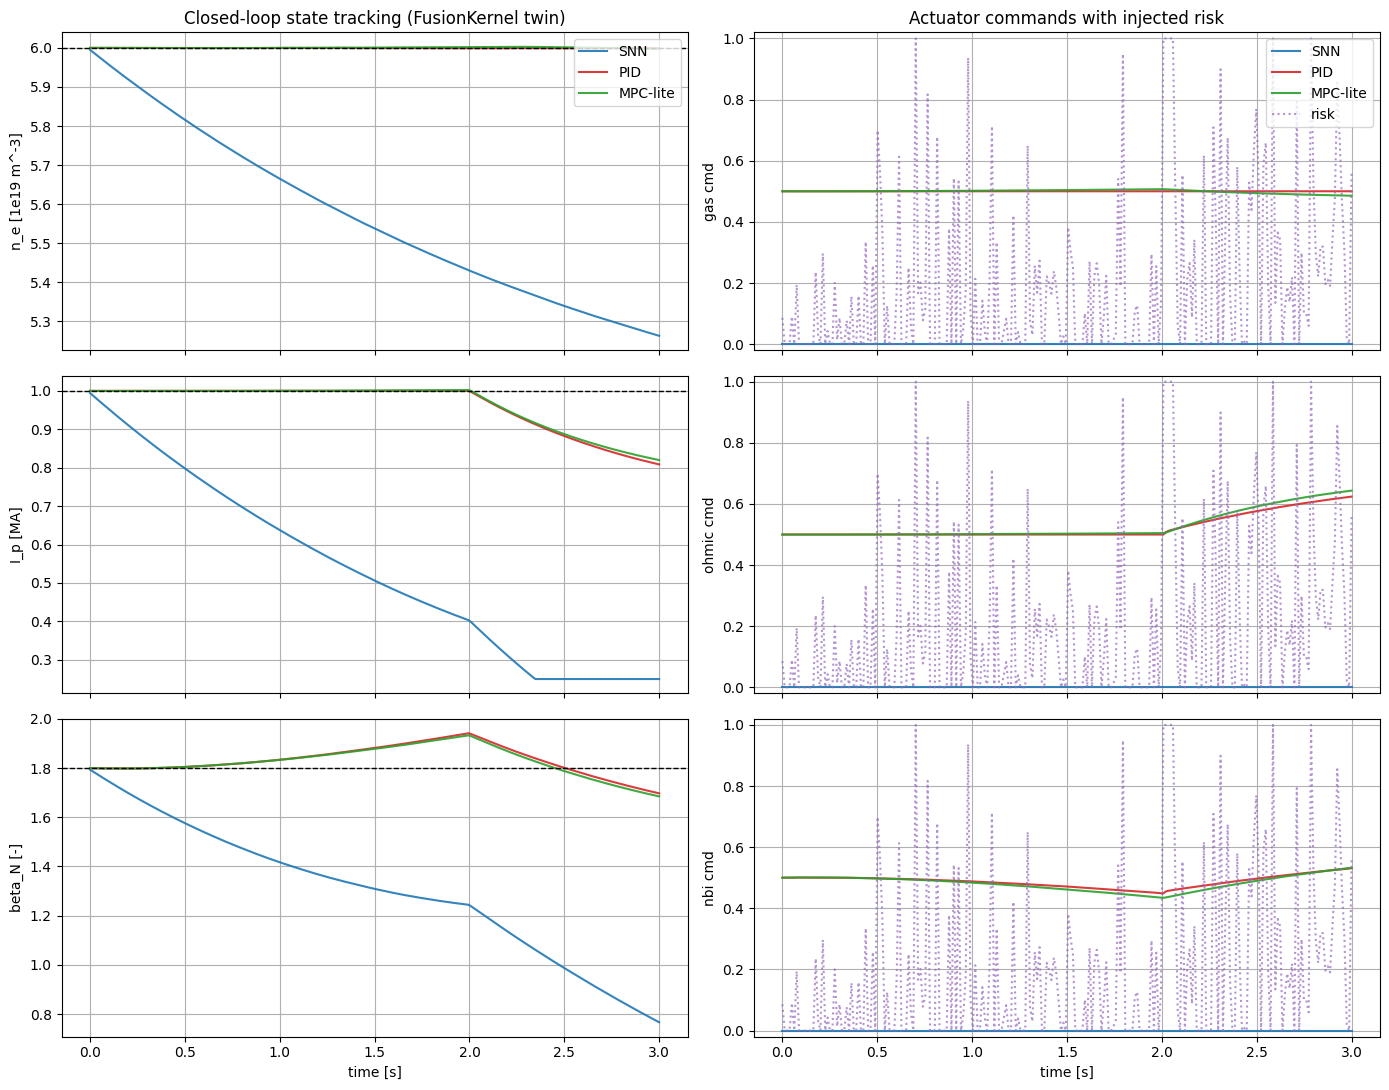


Quick winner snapshot (lower RMSE better):
  n_e: PID (0.0005)
  I_p: MPC-lite (0.0679)
  beta_N: MPC-lite (0.0647)
SILVER_BASE_METRICS_JSON_START
{
  "MPC-lite": {
    "controller": "MPC-lite",
    "critical_total": 0,
    "energy_err_p95": 0.006716524129188436,
    "gs_residual_p95": 2.199147656848889e-06,
    "gs_solve_mean_ms": 11.924760835730316,
    "gs_solve_p95_ms": 19.940984924323853,
    "latency_e2e_mean_ms": 12.593969161389396,
    "latency_e2e_p95_ms": 20.616749924374737,
    "latency_mean_ms": 0.19188875012332574,
    "latency_p95_ms": 0.3856700146570798,
    "mitigation_steps": 0,
    "mse_total": 0.0029327101739893883,
    "q_min_min": 1.6600000000000004,
    "rmse_beta": 0.06470035789657742,
    "rmse_ip": 0.06789817194433366,
    "rmse_ne": 0.0013536826218344578,
    "violations_total": 10
  },
  "PID": {
    "controller": "PID",
    "critical_total": 0,
    "energy_err_p95": 0.006737359071037118,
    "gs_residual_p95": 2.199147099513694e-06,
    "gs_solve_mean_ms": 

In [7]:
results = {
    "SNN": run_closed_loop("SNN", seed_offset=0),
    "PID": run_closed_loop("PID", seed_offset=0),
    "MPC-lite": run_closed_loop("MPC-lite", seed_offset=0),
}

records = [results[k]["metrics"] for k in ["SNN", "PID", "MPC-lite"]]

if HAS_PANDAS:
    df_metrics = pd.DataFrame(records).set_index("controller")
    display(df_metrics)
else:
    print("Controller metrics (pandas unavailable):")
    for rec in records:
        print(rec)

if HAS_MPL:
    colors = {"SNN": "tab:blue", "PID": "tab:red", "MPC-lite": "tab:green"}

    fig, axes = plt.subplots(3, 2, figsize=(14, 11), sharex="col")

    # State trajectories
    labels = ["n_e [1e19 m^-3]", "I_p [MA]", "beta_N [-]"]
    for i in range(3):
        ax = axes[i, 0]
        for name in ["SNN", "PID", "MPC-lite"]:
            ax.plot(T_SIM, results[name]["states"][:, i], label=name, color=colors[name], alpha=0.9)
        ax.axhline(TARGET[i], color="black", linestyle="--", linewidth=1.0)
        ax.set_ylabel(labels[i])
        ax.grid(True)
        if i == 0:
            ax.set_title("Closed-loop state tracking (FusionKernel twin)")

    axes[2, 0].set_xlabel("time [s]")
    axes[0, 0].legend(loc="upper right")

    # Control actions + risk
    for i, act_name in enumerate(["gas", "ohmic", "nbi"]):
        ax = axes[i, 1]
        for name in ["SNN", "PID", "MPC-lite"]:
            ax.plot(T_SIM, results[name]["actions"][:, i], label=name, color=colors[name], alpha=0.9)
        ax.plot(T_SIM, dist_risk, color="tab:purple", linestyle=":", alpha=0.7, label="risk" if i == 0 else None)
        ax.set_ylabel(f"{act_name} cmd")
        ax.set_ylim(-0.02, 1.02)
        ax.grid(True)
        if i == 0:
            ax.set_title("Actuator commands with injected risk")

    axes[2, 1].set_xlabel("time [s]")
    axes[0, 1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

print("\nQuick winner snapshot (lower RMSE better):")
for axis, key in [("n_e", "rmse_ne"), ("I_p", "rmse_ip"), ("beta_N", "rmse_beta")]:
    best = min(records, key=lambda r: r[key])
    print(f"  {axis}: {best['controller']} ({best[key]:.4f})")


metrics_export = {rec["controller"]: rec for rec in records}
print("SILVER_BASE_METRICS_JSON_START")
print(json.dumps(metrics_export, indent=2, sort_keys=True))
print("SILVER_BASE_METRICS_JSON_END")


## 7) Formal Contracts and Proof Prints

We evaluate invariant outcomes per controller, print violation snapshots, and emit deterministic proof hashes.


In [8]:
proof_rows = []
for name in ["SNN", "PID", "MPC-lite"]:
    r = results[name]
    m = r["metrics"]
    proof_payload = {
        "controller": name,
        "violations_total": m["violations_total"],
        "critical_total": m["critical_total"],
        "mitigation_steps": m["mitigation_steps"],
        "q_min_min": m["q_min_min"],
        "gs_residual_p95": m["gs_residual_p95"],
        "energy_err_p95": m["energy_err_p95"],
        "run_hash": r["run_hash"],
        "structural_proof_hash": proof_hash,
    }
    payload_json = json.dumps(proof_payload, sort_keys=True)
    payload_hash = hashlib.sha256(payload_json.encode("utf-8")).hexdigest()
    proof_payload["proof_hash"] = payload_hash
    proof_rows.append(proof_payload)

    print(f"\n=== {name} proof payload ===")
    print(json.dumps(proof_payload, indent=2))

    if r["first_violations"]:
        print("First recorded violations:")
        for item in r["first_violations"]:
            print(json.dumps(item, indent=2))
    else:
        print("No invariant violations recorded.")

if HAS_PANDAS:
    df_proofs = pd.DataFrame(proof_rows).set_index("controller")
    display(df_proofs[["violations_total", "critical_total", "mitigation_steps", "proof_hash"]])



=== SNN proof payload ===
{
  "controller": "SNN",
  "violations_total": 202,
  "critical_total": 165,
  "mitigation_steps": 165,
  "q_min_min": 1.6600000000000004,
  "gs_residual_p95": 2.19334069702352e-06,
  "energy_err_p95": 0.008202363917460738,
  "run_hash": "076ac93f12b971ea9611633dd3174188be2273420824d31671128ba4b244a9c5",
  "structural_proof_hash": "d38de0ff327b06df2e91fc8bc1cfda70daa072bbbb35f2e0097c870d22f5cb6a",
  "proof_hash": "4f6a25ff07fe7e61050e1e8fc2b4e0b2869b6687cc9c2e3c84203d69e1fb411a"
}
First recorded violations:
{
  "step": 38,
  "items": [
    {
      "name": "greenwald",
      "actual": 1.2035385135965158,
      "threshold": 1.2,
      "severity": "warning"
    }
  ]
}
{
  "step": 39,
  "items": [
    {
      "name": "greenwald",
      "actual": 1.2093755899838492,
      "threshold": 1.2,
      "severity": "warning"
    }
  ]
}
{
  "step": 40,
  "items": [
    {
      "name": "greenwald",
      "actual": 1.2152591775029065,
      "threshold": 1.2,
      "severit

,violations_total,critical_total,mitigation_steps,proof_hash
controller,,,,
SNN,202,165,165,4f6a25ff07fe7e61050e1e8fc2b4e0b2869b6687cc9c2e...
PID,16,0,0,502068c8380a454cee904a03456580695d183959eb8ba2...
MPC-lite,10,0,0,4249a18876f08be33b5cb43931188211e7c5c859771516...


## 8) Computational Cost and 3456x3456 Scaling

This notebook now reports two latency lanes:

- Controller-only latency: SNN/PID/MPC-lite inference path only
- End-to-end latency: controller + full `FusionKernel.solve_equilibrium()` + contract checks

Operational note:
- Real-time deployment should run a neural equilibrium surrogate in-loop.
- Full GS solve per control tick is computationally expensive and best treated as offline or low-rate supervisory validation.


,controller_p95_ms,e2e_p95_ms,gs_solve_p95_ms,controller_mean_ms,e2e_mean_ms,gs_solve_mean_ms,gs_share_pct
controller,,,,,,,
SNN,0.585435,27.589205,24.329685,0.255649,14.128783,13.359968,94.558516
PID,0.128725,29.184860,28.207195,0.050173,14.859170,14.272219,96.049906
MPC-lite,0.385670,20.616750,19.940985,0.191889,12.593969,11.924761,94.686279


Deployment note: end-to-end loop is dominated by GS equilibrium solve; use neural surrogate for real-time control tick rates.


SILVER_BASE_SCALE_JSON_START
{
  "max_ms": 8.59640003181994,
  "mean_ms": 6.1621167114935815,
  "min_ms": 4.362800042144954,
  "p95_ms": 8.362575026694685,
  "runs": 6,
  "shape": [
    3456,
    3456
  ],
  "y_l2": 3457.764404296875
}
SILVER_BASE_SCALE_JSON_END


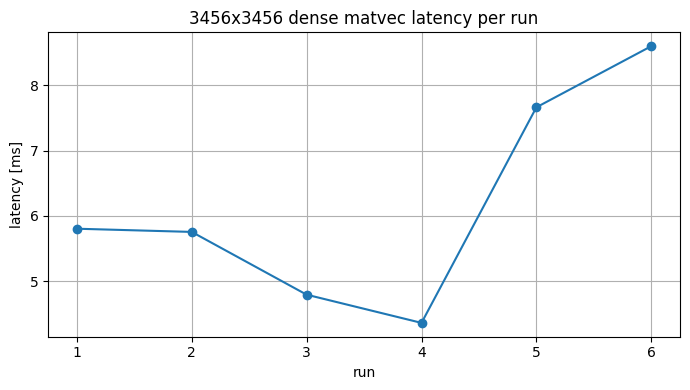

In [9]:
cost_rows = []
for name in ["SNN", "PID", "MPC-lite"]:
    m = results[name]["metrics"]
    gs_frac = 100.0 * m["gs_solve_mean_ms"] / max(m["latency_e2e_mean_ms"], 1e-9)
    cost_rows.append(
        {
            "controller": name,
            "controller_p95_ms": m["latency_p95_ms"],
            "e2e_p95_ms": m["latency_e2e_p95_ms"],
            "gs_solve_p95_ms": m["gs_solve_p95_ms"],
            "controller_mean_ms": m["latency_mean_ms"],
            "e2e_mean_ms": m["latency_e2e_mean_ms"],
            "gs_solve_mean_ms": m["gs_solve_mean_ms"],
            "gs_share_pct": gs_frac,
        }
    )

if HAS_PANDAS:
    df_cost = pd.DataFrame(cost_rows).set_index("controller")
    display(df_cost)
else:
    print(cost_rows)

print("Deployment note: end-to-end loop is dominated by GS equilibrium solve; use neural surrogate for real-time control tick rates.")

# Dense scaling benchmark at 3456x3456 (matrix-vector inference proxy)
SCALE_N = 3456
SCALE_RUNS = 6
rng_scale = np.random.default_rng(SEED + 123)
A = rng_scale.standard_normal((SCALE_N, SCALE_N), dtype=np.float32)
x = rng_scale.standard_normal(SCALE_N, dtype=np.float32)

_ = A @ x  # warmup
scale_ms = []
for _ in range(SCALE_RUNS):
    t0 = time.perf_counter()
    y = A @ x
    scale_ms.append((time.perf_counter() - t0) * 1e3)

scale_metrics = {
    "shape": [SCALE_N, SCALE_N],
    "runs": SCALE_RUNS,
    "mean_ms": float(np.mean(scale_ms)),
    "p95_ms": float(np.percentile(scale_ms, 95)),
    "min_ms": float(np.min(scale_ms)),
    "max_ms": float(np.max(scale_ms)),
    "y_l2": float(np.linalg.norm(y)),
}

print("SILVER_BASE_SCALE_JSON_START")
print(json.dumps(scale_metrics, indent=2, sort_keys=True))
print("SILVER_BASE_SCALE_JSON_END")

if HAS_MPL:
    plt.figure(figsize=(7, 4))
    plt.plot(np.arange(1, SCALE_RUNS + 1), scale_ms, marker="o")
    plt.title("3456x3456 dense matvec latency per run")
    plt.xlabel("run")
    plt.ylabel("latency [ms]")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## 9) Artifact Export and Deterministic Replay

We export a deployment artifact, reload it, and verify deterministic replay consistency of the SNN closed-loop run.


In [10]:
# Export artifact
artifact = compiled.export_artifact(
    name="silver_base_neuro_symbolic_control",
    dt_control_s=DT,
    readout_config={
        "actions": [
            {"name": "gas", "pos_place": PLACE_IDX["gas_puff"], "neg_place": PLACE_IDX["n_e_high"]},
            {"name": "ohmic", "pos_place": PLACE_IDX["ohmic_power"], "neg_place": PLACE_IDX["I_p_low"]},
            {"name": "nbi", "pos_place": PLACE_IDX["nbi_power"], "neg_place": PLACE_IDX["safety_interlock"]},
        ],
        "gains": [1.0, 1.0, 1.0],
        "abs_max": [1.0, 1.0, 1.0],
        "slew_per_s": [200.0, 200.0, 200.0],
    },
    injection_config=[
        {"place_id": PLACE_IDX["n_e"], "source": "n_e", "scale": 1.0, "offset": 0.0, "clamp_0_1": True},
        {"place_id": PLACE_IDX["I_p"], "source": "I_p", "scale": 1.0, "offset": 0.0, "clamp_0_1": True},
        {"place_id": PLACE_IDX["beta_N"], "source": "beta_N", "scale": 1.0, "offset": 0.0, "clamp_0_1": True},
    ],
)

fd, artifact_path = tempfile.mkstemp(suffix=".scpnctl.json")
os.close(fd)
save_artifact(artifact, artifact_path)
loaded_artifact = load_artifact(artifact_path)

with open(artifact_path, "rb") as f:
    artifact_sha = hashlib.sha256(f.read()).hexdigest()

print(f"Artifact path: {artifact_path}")
print(f"Artifact SHA256: {artifact_sha}")
print(f"Loaded artifact name: {loaded_artifact.meta.name}")
print(f"Loaded topology: nP={loaded_artifact.nP}, nT={loaded_artifact.nT}")

# Deterministic replay check (same seed, same disturbance)
snn_run_a = run_closed_loop("SNN", seed_offset=77)
snn_run_b = run_closed_loop("SNN", seed_offset=77)

same_hash = snn_run_a["run_hash"] == snn_run_b["run_hash"]
state_equal = np.allclose(snn_run_a["states"], snn_run_b["states"], atol=0.0, rtol=0.0)
action_equal = np.allclose(snn_run_a["actions"], snn_run_b["actions"], atol=0.0, rtol=0.0)

replay_payload = {
    "artifact_sha256": artifact_sha,
    "run_hash_a": snn_run_a["run_hash"],
    "run_hash_b": snn_run_b["run_hash"],
    "hash_equal": bool(same_hash),
    "state_equal": bool(state_equal),
    "action_equal": bool(action_equal),
}
replay_proof_hash = hashlib.sha256(json.dumps(replay_payload, sort_keys=True).encode("utf-8")).hexdigest()

print("\nDeterministic replay payload:")
print(json.dumps(replay_payload, indent=2))
print(f"Replay proof SHA256: {replay_proof_hash}")

assert same_hash and state_equal and action_equal, "Deterministic replay failed"

if os.path.exists(artifact_path):
    os.unlink(artifact_path)


Artifact path: C:\Users\forti\AppData\Local\Temp\tmpru7tjw5m.scpnctl.json
Artifact SHA256: a5b438e70df85038ad922cbc3f948bf9d3df4a2a89ba874ec5f4e9d1273e25e5
Loaded artifact name: silver_base_neuro_symbolic_control
Loaded topology: nP=12, nT=6



Deterministic replay payload:
{
  "artifact_sha256": "a5b438e70df85038ad922cbc3f948bf9d3df4a2a89ba874ec5f4e9d1273e25e5",
  "run_hash_a": "076ac93f12b971ea9611633dd3174188be2273420824d31671128ba4b244a9c5",
  "run_hash_b": "076ac93f12b971ea9611633dd3174188be2273420824d31671128ba4b244a9c5",
  "hash_equal": true,
  "state_equal": true,
  "action_equal": true
}
Replay proof SHA256: af4c402ad8d15df4234ed50926be00c37b1a94107ba0fe4b64f1d68fb3825d27


## Summary

This Silver Base notebook demonstrates:

- Petri net control logic over density/current/beta
- SNN compilation with stochastic-path support when available
- Explicit `sc_neurocore` API-path run check
- Closed-loop operation with a `FusionKernel` equilibrium twin
- DIII-D disturbance injection from the bundled shot profile
- SNN vs PID/MPC-lite quantitative comparison
- Formal contract checks with proof hashes
- Computational-cost evidence (controller vs full-loop)
- 3456x3456 dense scaling benchmark
- Artifact export and deterministic replay proof

Deployment note:
- This is toy-scale closed-loop inference.
- Production deployment should add sensor preprocessing, actuator lag compensation, and neural equilibrium surrogates to avoid full GS solve on every real-time tick.
